<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Chart_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> SETUP </H1>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#For now - 7 classes: Area chart, Bar chart, Line Chart, pie chart, scatter plot. 100 images per class. 80/20 train/val split
#train_dir = '/content/drive/My Drive/Colab Notebooks/Train'
#validation_dir = '/content/drive/My Drive/Colab Notebooks/Validation'

train_dir = '/content/drive/My Drive/Colab Notebooks/Charts_5/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/Charts_5/Validation'


<H1>BASELINE MODEL</H1>

In [4]:
#List of all basic tunable parameters of the model - to be updated
img_width, img_height = 224, 224
nb_train_samples = 400
nb_validation_samples = 100
epochs = 100
batch_size = 16

In [5]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [6]:
#Performing augmentation on image scaling, zoom and fliiping the images horizontally so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2, 
	horizontal_flip=True) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [7]:
sample_training_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

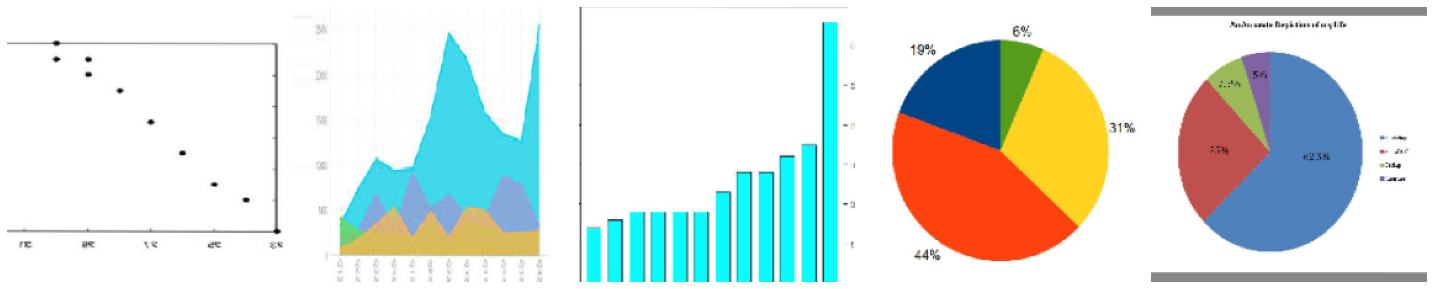

In [8]:
plotImages(sample_training_images[:5])

TRANSFER LEARNING

In [100]:
base_model = tf.keras.applications.VGG16(weights=None, include_top=False, input_shape=input_shape, classes=5)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [101]:
base_model.trainable=False

In [102]:
inputs = keras.Input(shape=input_shape)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(5)(x)
tl_model = keras.Model(inputs, outputs)

In [103]:
tl_model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

tl_history = tl_model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=100, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Epoch 1/100
25/25 [==============================] - 10s 397ms/step - loss: 6.8565 - accuracy: 0.2175 - val_loss: 8.7306 - val_accuracy: 0.2083
Epoch 2/100
25/25 [==============================] - 10s 386ms/step - loss: 8.9455 - accuracy: 0.2000 - val_loss: 10.4096 - val_accuracy: 0.2083
Epoch 3/100
25/25 [==============================] - 10s 394ms/step - loss: 9.9529 - accuracy: 0.2000 - val_loss: 10.0738 - val_accuracy: 0.1875
Epoch 4/100
25/25 [==============================] - 10s 389ms/step - loss: 9.6709 - accuracy: 0.2000 - val_loss: 10.0738 - val_accuracy: 0.1771
Epoch 5/100
25/25 [==============================] - 10s 397ms/step - loss: 9.7917 - accuracy: 0.2000 - val_loss: 10.4096 - val_accuracy: 0.1979
Epoch 6/100
25/25 [==============================] - 10s 399ms/step - loss: 9.7514 - accuracy: 0.2000 - val_loss: 9.9059 - val_accuracy: 0.1875
Epoch 7/100
25/25 [==============================] - 10s 398ms/step - loss: 9.6306 - accuracy: 0.2000 - val_loss: 10.4096 - val_accu

KeyboardInterrupt: ignored

VGG16 KERAS - from scratch

In [9]:
vgg_model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same',activation='relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
   
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
   
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
   
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(5, activation='softmax')
])

vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [10]:
from tensorflow.keras.optimizers import Adam

vgg_model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [11]:
vgg_history = vgg_model.fit( 
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size, 
  epochs=30, 
  validation_data=validation_generator, 
  validation_steps=nb_validation_samples // batch_size) 

Epoch 1/30
25/25 [==============================] - 45s 2s/step - loss: 2.1551 - accuracy: 0.1875 - val_loss: 1.6092 - val_accuracy: 0.2083
Epoch 2/30
25/25 [==============================] - 13s 507ms/step - loss: 1.6115 - accuracy: 0.1650 - val_loss: 1.6095 - val_accuracy: 0.1979
Epoch 3/30
25/25 [==============================] - 13s 507ms/step - loss: 1.6108 - accuracy: 0.1750 - val_loss: 1.6100 - val_accuracy: 0.1979
Epoch 4/30
25/25 [==============================] - 13s 505ms/step - loss: 1.6102 - accuracy: 0.1850 - val_loss: 1.6094 - val_accuracy: 0.2083
Epoch 5/30
25/25 [==============================] - 13s 506ms/step - loss: 1.6099 - accuracy: 0.2000 - val_loss: 1.6095 - val_accuracy: 0.1979
Epoch 6/30
25/25 [==============================] - 13s 510ms/step - loss: 1.6098 - accuracy: 0.1875 - val_loss: 1.6094 - val_accuracy: 0.1979
Epoch 7/30
25/25 [==============================] - 13s 506ms/step - loss: 1.6100 - accuracy: 0.1650 - val_loss: 1.6094 - val_accuracy: 0.2083
Ep